#Model formål

Genkende hunderacer med et givet billede. Derudover skal modellen også kunne genkende hvorvidt et givent billede af en hund er en blandingsrace eller ej.

# Step 1 - Collect data

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.8MB/s 
     |████████████████████████████████| 1.2MB 27.6MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 204kB 48.1MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *
from fastai.callback.fp16 import *

Da vi skulle kunne genkende forskellige hunderacer, samt hvorvidt en given hund er et “gadekryds”, var vores første opgave at finde et passende dataset. Tíl at genkende hunderacerne brugte vi Stanford Dogs datasættet fra Kaggle, der består af over 20.000 billeder fordelt på 120 hunderacer. Vi overvejede også at bruge metoder til at skrabe enten Bing eller Google for hundebilleder, men da den fremgangsmåde ville kræve meget mere finkæmning af data, valgte vi at gå med det allerede eksisterende datasæt fra Kaggle. 

In [ ]:
!unzip '/content/gdrive/MyDrive/dogs.zip' -d '/content/'

In [ ]:
train_path = Path('/content/dogs')

I forhold til gadekryds var vi dog nødsaget til at lave vores datasæt ud fra google-images søgning, men da det nu kun omhandlede “en” type hund og ikke samtlige hunderacer, var det også mere realistisk at nå i mål med finkæmningen af dataet. 
Det fungerer sådan at man henter en fil med google images url’er, og derefter uploader man denne til Colab, hvor man så med lidt kode kan downloade billederne fra disse url’er og derefter placerede vi så disse billeder i en crossbreeds mappe på linje med de andre hunderacer.



In [ ]:
folder = 'crossbreed'
file = 'urls_crossbreed.csv'

In [ ]:
dest = train_path/folder
dest.mkdir(parents=True, exist_ok=True)

In [ ]:
download_images(dest, path/file, max_pics=120)

Herfra lavede vi en zip fil, der indeholder alle billeder med crossbreeds, som vi unzipper samme sted som vi unzippede hunde datasettet før

In [ ]:
!unzip '/content/gdrive/MyDrive/crossbreeds-20210521T102410Z-001.zip' -d '/content/dogs'

Størstedelen af finkæmningen har bestået af at fjerne duplikater, samt billeder der, fordi det er google, slet ikke består af hunde.

In [ ]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink)

In [ ]:
def get_y(r): return L(parent_label(r))

In [ ]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

# Step 2 - Data Preparation

In [ ]:
def get_dls(bs, size):
  dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                     splitter=RandomSplitter(valid_pct=0.2, seed=42),
                     get_items=get_image_files,
                     get_y=get_y,
                     item_tfms=RandomResizedCrop(128, min_scale=0.3),
                     batch_tfms=aug_transforms(size=size)
                     )
  return dblock.dataloaders(train_path, bs=bs)

Den første data preparation teknik er en splitter. Dermed splitter vi 20% af vores dataset ud i et valideringssæt, som bliver brugt under træningsprocessen.

RandomresizedCrop brugte vi til at tage snippet med en specifikt størrelse ud af et billedé og ændrer dens aspect ratio. Det gør dataen mere generaliseret.

Batch transformation bruges til at croppe billederne til samme størrelse for at gøre det muligt at smide en batch af billeder til GPU´en.
Aug_transform roterer, flipper, warper, zoomer og ændrer kontrasten samt lysstyrken på billederne.

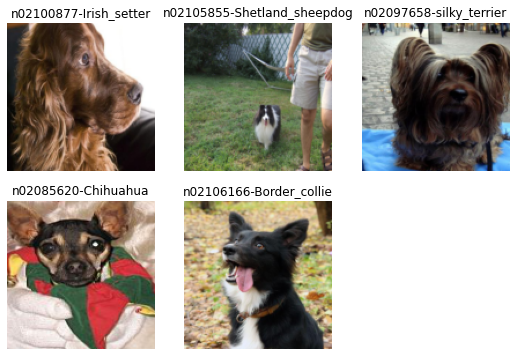

In [ ]:
dls = get_dls(128, 128)
dls.valid.show_batch(max_n=5, nrows=2)

# Step 3 - Choose model

Formålet med at benytte denne model var at se hvad forskellen på VGG og resnet er. Hvilke resultater de kommer med, samt at prøve at lave vores egen implementering af et netværk. Her tænkte vi, at vi ville bruge et VGG-16 netværk som vores træningsmodel, da den er lavet til large-scale images. Det krævede dog at vi selv skulle træne modellen, men formålet med at opsætte modellen selv var at få en større forståelse for hvad der sker inde i boksen.
Ideen er som sagt at implementere VGG16 selv og måden VGG16 fungerer er at den først tager et input af størrelse 224x224 pixels med 3 channels, altså et RGB billede. Derefter går det igennem nogle convolution lag, hvor vi har et stride på 2 og padder billedet 1 pixel af gangen. Hvert lag bruger også en ReLu funktion. Til sidst i modellen er der et softmax lag.

In [ ]:
def get_model():
    return nn.Sequential(
        #first to layer
        ConvLayer(3,64, stride=1),
        ConvLayer(64,64, stride=1),

        #second layer
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ConvLayer(64,128, stride=1),
        ConvLayer(128,128, stride=1),

        #third layer
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ConvLayer(128,256, stride=1),
        ConvLayer(256,256, stride=1),
        ConvLayer(256,256, stride=1),

        #fourth layer
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ConvLayer(256, 512, stride=1),
        ConvLayer(512,512, stride=1),
        ConvLayer(512,512, stride=1),

        #Fifth layer
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ConvLayer(512,512, stride=1),
        ConvLayer(512,512, stride=1),
        ConvLayer(512,512, stride=1),

        #End
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

        Flatten(),
        nn.Linear(512, 4096),
        nn.Linear(4096,4096),
        nn.Linear(4096, 120),
        nn.Softmax(dim=1)
        )

In [ ]:
vgg_learner = Learner(dls, get_model(), loss_func=nn.CrossEntropyLoss(), metrics=accuracy).to_fp16()

Vi startede med at bruge accuracy_multi, fordi vi ville bruge vores model til at gætte på blandede racer og troede at for at få 2 eller flere labels på et billede, skulle vi bruge accuracy_multi.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Vi bruger fp16 til at gøre træningen hurtigere, dog med lidt dårligere resultat

In [ ]:
#learn = learn.load('resnet18_multi_category')

# Step 4 - Train Model

Når vi først træner vores model tager vi et lavt antal epochs først. Dette gør vi for lige at få en fornemmelse for hvordan modellen klarer sig, før vi begynder at bruge lang tid på at træne.
Første gang vi træner vælger vi en tilfældig learning rate, da vi ikke ved hvordan det vil fungerer endnu og vi gerne vil have et udgangspunkt før vi begynder at pille for meget med de forskellige parametre.

Når vi sætter modellen til at træne går den igennem 7 steps:
Initialize the parameters: Først sætter vi vores weights tilfældigt

Calculate the predictions: Udregner

Calculate the loss

Calculate the gradients

Step the weights

Repeat the process

Stop


In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.892570,0.572330,0.072458,01:28
1,0.191248,0.052329,0.991739,01:28
2,0.063645,0.043283,0.991820,01:28
3,0.049344,0.041396,0.991913,01:28
4,0.046851,0.040727,0.991937,01:28


Efter træningen er færdig giver modellen os nogle tal, der fortæller os hvordan modellen har klaret sig.

Progressive resizing

In [ ]:
learn.dls = get_dls(64, 224)

In [ ]:
learn.fine_tune(5, base_lr=1e-6)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.045587,0.036385,0.992033,01:34


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.045448,0.036473,0.992063,01:38
1,0.044707,0.036427,0.992077,01:38
2,0.044614,0.036342,0.992057,01:38
3,0.044757,0.036230,0.992077,01:41
4,0.045245,0.036088,0.992087,01:38


# Step 5 - Evaluation

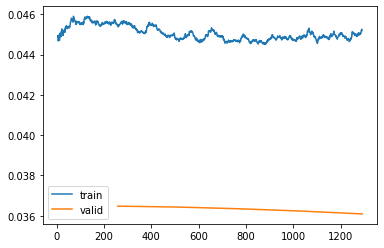

In [ ]:
learn.recorder.plot_loss()

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=3.981071586167673e-06)

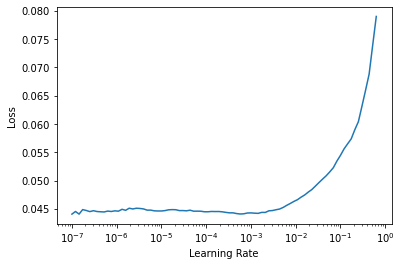

In [ ]:
learn.lr_find()

Vi startede ud med at bruge MultiCategoryBlock classification, hvor resultater af vores model var meget unøjagtige. Vores model var alt for selvsikker. Dens accuracy gik over 99% meget hurtigt.

I starten vidste vi ikke hvorfor denne model var så præcis, derfor forsøgte vi at justere modellens threshold for at undersøge om den forholder sig til vores definerede threshold, som vi kunne konkludere at den ikke gjorde. Her forblev forudsigelserne stadigvæk alt for præcise.

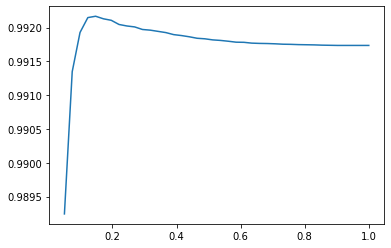

In [ ]:
preds, targs = learn.get_preds()

xs = torch.linspace(0.05,1,40) 
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs] 
plt.plot(xs,accs);




Som tidligere nævnt brugte vi MultiCategoryBlock som vi fandt ud af var en forkert classification i vores tilfælde. Vi kom frem til at vores model, ikke var i stand til at lave acceptable forudsigelser på vores datasæt, hvor den tilsyneladende ignorerer vores threshold parameters og dermed lavede forudsigelser, som i vores øjne virkede urealistiske. Dette skyldes at vi var kommet til at benytte os af multilabel classification frem for den ønskede multi category. Ved ændring af dette kom vi frem til resultater som var mere åbenlyse.

Det gjorde vi ved at ændre MultiCategoryBlock til CategoryBlock og bruge nn.CrossEntropyLoss som optimizer.

In [ ]:
def get_dls(bs, size):
  dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     splitter=RandomSplitter(valid_pct=0.2, seed=42),
                     get_items=get_image_files,
                     get_y=parent_label,
                     item_tfms=RandomResizedCrop(128, min_scale=0.3),
                     batch_tfms=aug_transforms(size=size)
                     )
  return dblock.dataloaders(train_path, bs=bs)

In [ ]:
dls = get_dls(128,128)

In [ ]:
loss = nn.CrossEntropyLoss()
learn = cnn_learner(dls, resnet18, metrics=accuracy, loss_func=loss).to_fp16()

For at have lidt mere indblik i hvad modellen predictede gør vi brug af Confusion matrix

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,3.510610,1.776576,0.513540,01:26
1,2.375955,1.545592,0.572534,01:25


In [ ]:
learn.dls = get_dls(64,256)

In [ ]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.730646,0.972300,0.698017,01:33


epoch,train_loss,valid_loss,accuracy,time
0,1.422808,0.841520,0.752176,01:37
1,1.133231,0.739572,0.779014,01:37


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=5)

In [ ]:
interp.plot_confusion_matrix(figsize=(48,48))

Tidligere har vi brugt confusion matrix, hvor det viste sig at modellen havde svært ved særligt 4 hunderacer. Hvis vi kigger på vores data kan vi se at disse racer meget ligner hinanden og dermed bedre forstå hvorfor vores model kan forveksle dem med hinanden.
Vi kan også rette vores data til efter, eller forsøge at forstå hvilke billeder den gætter forkert på og hvorfor.

# Step 6 - Tuning

For at øge accuracy af modellen implementerer vi yderligere teknikker.
Vi begynder ved DataBlock´en, hvor vi tilføjer Normalization i batch transformation.
Vi vil også bruge progressive resizing når vi skal træne vores model.

In [ ]:
def get_dls(bs, size):
  dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     splitter=RandomSplitter(valid_pct=0.2, seed=42),
                     get_items=get_image_files,
                     get_y=parent_label,
                     item_tfms=RandomResizedCrop(128, min_scale=0.3),
                     batch_tfms=[*aug_transforms(size=size), Normalize()]
                     )
  return dblock.dataloaders(train_path, bs=bs)

In [ ]:
dls = get_dls(128, 128)

Så tilføjer vi MixUp til vores cnn_learner.
Derudover tilføjer vi også Label Smoothing til vores træning.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy, loss_func=LabelSmoothingCrossEntropy(), cbs=MixUp).to_fp16()

Som vi har observeret i vores evaluering er der plads til flere epochs i vores træning.

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,5.892113,3.796050,0.194633,01:30
1,4.361841,2.472106,0.506770,01:26
2,3.707605,2.202650,0.570841,01:26
3,3.413938,2.136667,0.589700,01:29
4,3.254255,2.074065,0.604691,01:28
5,3.160493,2.041378,0.616296,01:26
6,3.079693,2.010094,0.623308,01:27
7,3.026370,1.985075,0.639507,01:27
8,3.002722,1.979679,0.639749,01:27
9,2.997378,1.977029,0.641683,01:28


In [ ]:
learn.dls = get_dls(64, 256)

In [ ]:
learn.fine_tune(7)

epoch,train_loss,valid_loss,accuracy,time
0,3.016368,1.800929,0.698743,01:37


epoch,train_loss,valid_loss,accuracy,time
0,2.833165,1.632907,0.759188,01:40
1,2.793709,1.669587,0.738395,01:39
2,2.759622,1.652440,0.744681,01:39
3,2.643527,1.577401,0.769342,01:39
4,2.578503,1.534416,0.780948,01:39
5,2.530799,1.512727,0.789410,01:39
6,2.489577,1.508128,0.789410,01:40


# Step 7 - Prediction

Her finder vi et tilfældigt hunde-billede og uploader det til Jupyter Notebook

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

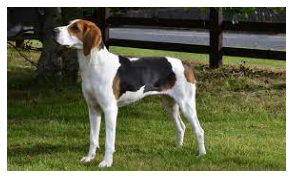

In [ ]:
img = PILImage.create(btn_upload.data[-1])
img.show()

Vi predicter på vores billede

In [ ]:
pred,pred_idx,probs = learn.predict(img)

In [ ]:
pred_value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
pred_value

'Prediction: n02089867-Walker_hound; Probability: 0.4911'

Vi kan se hvad modellen predicter på vores billede

Hvis vi havde et test sæt ville vi kunne predicte over det i stedet for at tage et tilfældigt billede fra Google

In [ ]:
learn.save("dog_classifier")

Path('models/dog_classifier.pth')

Når/hvis vi er tilfreds med vores model, kan vi gemme den

In [ ]:
learn.load("dog_classifier")

Vi kan hente vores model ind i vores projekt, hvis vi vil bruge den senere eller til fremtidige projekter